# **Libraries**

---



In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import matplotlib.pyplot as plt

# **Preproccessing**

---




In [ ]:
!gdown --id 1OmJKqqWO1JXzZ0FG0Rxh8VRig3KMqNcV
dataset = pd.read_csv('/content/dataset.csv')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OmJKqqWO1JXzZ0FG0Rxh8VRig3KMqNcV
To: /content/dataset.csv
100% 38.0k/38.0k [00:00<00:00, 27.7MB/s]


In [ ]:
categorical_attr = ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays', 'Class']

le = LabelEncoder()
dataset[categorical_attr] = dataset[categorical_attr].apply(le.fit_transform, axis=0)
dataset.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1,4,4,2,1,0,7,0,0,15,16,2,20,1,1,1,2
1,1,4,4,2,1,0,7,0,0,20,20,3,25,1,1,1,2
2,1,4,4,2,1,0,7,0,0,10,7,0,30,0,0,0,1
3,1,4,4,2,1,0,7,0,0,30,25,5,35,0,0,0,1
4,1,4,4,2,1,0,7,0,0,40,50,12,50,0,0,0,2


In [ ]:
X = np.array(dataset.iloc[:, :-1]).reshape(480, 16)
y = np.array(dataset.iloc[:, -1]).reshape(480, 1)

# [H, M, L]
# e.g. [1, 0, 0] -> H 

def convertTo3Class(arr):
  tmp = np.zeros((arr.shape[0], 3))
  tmp[np.where(arr==0)[0], :] = [1, 0, 0]
  tmp[np.where(arr==1)[0], :] = [0, 0, 1]
  tmp[np.where(arr==2)[0], :] = [0, 1, 0]
  return tmp


y = convertTo3Class(y)  # convert y to 3 classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# **Implementation**

---



**Neural network class and functions**

In [ ]:
# function for convert probablity to 0s and 1s for multiple classification
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

class DenseModel:
  def __init__(self, activation, l=3, dropout=False, batch_normalization=False):
    self.model = Sequential()
    # -------------- layer 1 --------------
    if dropout:
      self.model.add(Dropout(0.1, input_dim=16))
      self.model.add(Dense(32, activation=activation))
    if batch_normalization:
      self.model.add(BatchNormalization(input_dim=16))
    else:
      self.model.add(Dense(32, activation=activation, input_dim=16))
    
    
    if batch_normalization:
      self.model.add(BatchNormalization())
    if dropout:
      self.model.add(Dropout(0.2))
    # -------------- layer 2 --------------
    self.model.add(Dense(32, activation=activation))
  
    if batch_normalization:
      self.model.add(BatchNormalization())
    if dropout:
      self.model.add(Dropout(0.2))

    # -------------- layer 3 --------------
    self.model.add(Dense(16, activation=activation))

    if batch_normalization:
      self.model.add(BatchNormalization())
    if dropout:
      self.model.add(Dropout(0.1))

    # -------------- layer 4 --------------
    if l > 3:
      self.model.add(Dense(16, activation=activation))

      if batch_normalization:
        self.model.add(BatchNormalization())
      if dropout:
        self.model.add(Dropout(0.1))

    # -------------- layer 5 --------------
    if l > 4:
      self.model.add(Dense(8, activation=activation))

      if batch_normalization:
        self.model.add(BatchNormalization())
      if dropout:
        self.model.add(Dropout(0))

    # -------------- output layer --------------
    self.model.add(Dense(3, activation='softmax'))

  def train(self, X_train, y_train, validation_data, optimizer, epoch, learning_rate, lr_schedule_parameters=(1000, 0.95)):
    self.X_train = X_train
    self.y_train = y_train

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate=learning_rate,
                      decay_steps=lr_schedule_parameters[0],
                      decay_rate=lr_schedule_parameters[1],
                      staircase=True)

    optimizer = optimizer.lower()
    if optimizer == 'rms':
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    elif optimizer == 'adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)
    elif optimizer == 'nadam':
      optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # best model based on validation accuracy will save in this path
    filepath = 'my_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                                  monitor='val_accuracy',
                                  verbose=0, 
                                  save_best_only=True,
                                  mode='max')

    h = self.model.fit(X_train, y_train, validation_data=validation_data, batch_size=32, epochs=epoch, verbose=0, callbacks=[checkpoint])
    # best model assign to final model
    self.model = load_model(filepath)
    self.history = h.history

  def evaluate(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
    self.test_result = self.model.evaluate(X_test, y_test, verbose=0)

  def outputResult(self):
    print("result in training set:", "\ntrain acc= ", self.history['accuracy'], "\ntrain loss= ", self.history['loss'])
    print("\nresult in test set:", "\ntest acc= ", self.history['val_accuracy'], "\ntest loss= ", self.history['val_loss'], '\n')

    # best models based on acc or loss in tarin set or test set
    trainHistory = list(map(lambda x,y: [x, y], self.history['accuracy'], self.history['loss']))
    testHistory = list(map(lambda x,y: [x, y], self.history['val_accuracy'], self.history['val_loss']))
    print(f"\nbest model based on min training set loss:  acc= {min(trainHistory, key = lambda k: k[1])[0]}  loss= {min(trainHistory, key = lambda k: k[1])[1]}")
    print(f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(f"best model based on max training set accuracy:  acc= {max(trainHistory, key = lambda k: k[0])[0]}  loss= {max(trainHistory, key = lambda k: k[0])[1]}")
    print(f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate train set= ", self.model.evaluate(self.X_train, self.y_train, verbose=0))
    print("evaluate test set= ", self.test_result)

    y_train_pred = self.model.predict(self.X_train)
    y_train_pred = argmaxKeepDimensions(y_train_pred) #convert probablities to 0s and 1s
    
    y_test_pred = self.model.predict(self.X_test)
    y_test_pred = argmaxKeepDimensions(y_test_pred) #convert probablities to 0s and 1s
    
    # confusion matrix and precision, recall and f1 report
    print('\n', '-'*30, 'metrics for traning set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(np.argmax(self.y_train, axis=1), np.argmax(y_train_pred, axis=1)))
    print(metrics.classification_report(self.y_train, y_train_pred, digits=3, target_names=['H', 'M', 'L']))

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(np.argmax(self.y_test, axis=1), np.argmax(y_test_pred, axis=1)))
    print(metrics.classification_report(self.y_test, y_test_pred, digits=3, target_names=['H', 'M', 'L']))

  def showPlots(self):
    plt.plot(self.history['accuracy'], label='training accuracy', marker='.', color='green')
    plt.plot(self.history['val_accuracy'], label='test accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(self.history['loss'], label='training loss', marker='.', color='green')
    plt.plot(self.history['val_loss'], label='test loss', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


**K fold cross validation function implement**




In [ ]:
# k fold cross validation code

def kfoldOnModel(inputs, targets, activation, optimizer, layers_number=3, dropout=False, batch_normalization=False, k=5):
  kfold = KFold(n_splits=k, shuffle=True)

  fold_no = 1
  for train, test in kfold.split(inputs, targets):
    model = DenseModel(activation, l=layers_number, dropout=dropout, batch_normalization=batch_normalization).model

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
                        batch_size=32,
                        epochs=50,
                        verbose=0)

    # predict y_hat for test set
    y_hat_test = model.predict(inputs[test])
    y_hat_test = argmaxKeepDimensions(y_hat_test) #convert probablities to 0s and 1s

    # Generate generalization metrics and cofusion matrix
    evaluation_result = model.evaluate(inputs[test], targets[test], verbose=0)

    print(f'Result for fold {fold_no}: Loss= {evaluation_result[0]}  Acc= {evaluation_result[1]*100}% \n')
    print("confusion matrix: \n", metrics.confusion_matrix(np.argmax(targets[test], axis=1), np.argmax(y_hat_test, axis=1)))
    print(metrics.classification_report(targets[test], y_hat_test, digits=3, target_names=['H', 'M', 'L']))

    # Increase fold number
    fold_no = fold_no + 1

# **Simple Dense Models**

---

result in training set: 
train acc= 
['0.3516', '0.4557', '0.4557', '0.5599', '0.5859', '0.5911', '0.6120', '0.6094', '0.6484', '0.6250']
['0.6406', '0.6771', '0.6641', '0.7188', '0.7005', '0.7266', '0.7448', '0.7604', '0.7500', '0.7135']
['0.7682', '0.7760', '0.7344', '0.7422', '0.7682', '0.7344', '0.7630', '0.7526', '0.7474', '0.7682']
['0.7604', '0.7448', '0.7917', '0.7552', '0.7474', '0.7943', '0.7943', '0.7995', '0.8177', '0.8021']
['0.8151', '0.8203', '0.8307', '0.8411', '0.8125', '0.8099', '0.8333', '0.8464', '0.8438', '0.8411']
['0.8281', '0.8620', '0.8281', '0.8125', '0.8411', '0.8438', '0.8516', '0.7448', '0.7786', '0.8151']
['0.8568', '0.8385', '0.8516', '0.8047', '0.8438', '0.8229', '0.8411', '0.8203', '0.8438', '0.8594']
['0.8620', '0.8307', '0.8776', '0.8724', '0.8880', '0.8750', '0.8568', '0.8594', '0.8411', '0.8698']
['0.8698', '0.8698', '0.8776', '0.8516', '0.8516', '0.8724', '0.8880', '0.8750', '0.8698', '0.8880']
['0.8854', '0.8958', '0.8776', '0.8932', '0.8724', '0.

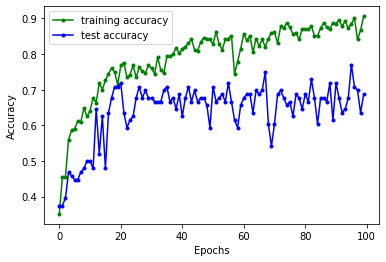

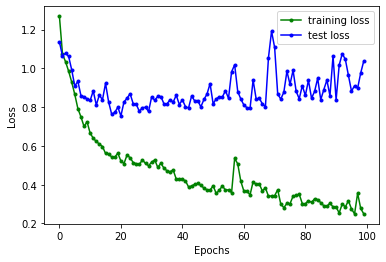

In [ ]:
# 4  layer NN without dropout and batch normalization
model_1 = DenseModel('sigmoid')
model_1.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01)
model_1.evaluate(X_test, y_test)
model_1.outputResult()
model_1.showPlots()

result in training set: 
train acc= 
['0.3568', '0.5000', '0.5469', '0.5755', '0.6406', '0.6432', '0.6380', '0.6667', '0.6667', '0.6198']
['0.6484', '0.6719', '0.6901', '0.6693', '0.7240', '0.7161', '0.7161', '0.7031', '0.7161', '0.7083']
['0.7578', '0.7214', '0.7344', '0.7448', '0.7422', '0.7708', '0.7240', '0.7760', '0.7682', '0.7448']
['0.7656', '0.7552', '0.8203', '0.8073', '0.7839', '0.8229', '0.8099', '0.7656', '0.8021', '0.8047']
['0.8307', '0.8229', '0.8203', '0.8229', '0.8307', '0.7995', '0.8203', '0.8073', '0.7865', '0.8177']
['0.8203', '0.8516', '0.8490', '0.7734', '0.8125', '0.7995', '0.7839', '0.8411', '0.8385', '0.8594']
['0.8516', '0.8438', '0.8438', '0.8698', '0.8802', '0.8828', '0.8672', '0.8594', '0.8464', '0.8203']
['0.8151', '0.8750', '0.8203', '0.8438', '0.8490', '0.8542', '0.8568', '0.8359', '0.8646', '0.8906']
['0.8958', '0.8932', '0.8672', '0.8724', '0.8568', '0.8411', '0.8776', '0.8802', '0.8828', '0.8854']
['0.8698', '0.8698', '0.8854', '0.8854', '0.8594', '0.

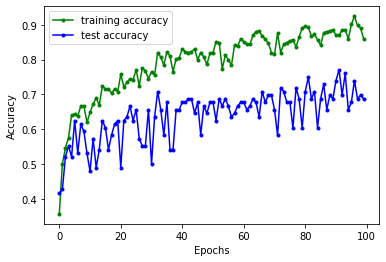

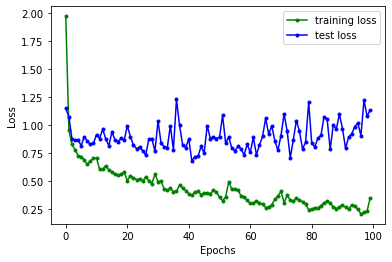

In [ ]:
# 4  layer NN without dropout and batch normalization
model_2 = DenseModel('relu')
model_2.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01, (2000, 0.99))
model_2.evaluate(X_test, y_test)
model_2.outputResult()
model_2.showPlots()

result in training set: 
train acc= 
['0.4557', '0.5234', '0.5859', '0.5885', '0.6484', '0.6198', '0.6120', '0.6745', '0.6797', '0.6667']
['0.6797', '0.7370', '0.7318', '0.7161', '0.7109', '0.7240', '0.7057', '0.7214', '0.7318', '0.7396']
['0.6432', '0.7656', '0.7708', '0.7839', '0.7708', '0.7526', '0.7786', '0.7969', '0.7891', '0.7891']
['0.7943', '0.8281', '0.7943', '0.8125', '0.8125', '0.7760', '0.8151', '0.8359', '0.7474', '0.8125']
['0.7891', '0.7604', '0.8073', '0.8177', '0.8125', '0.8229', '0.8385', '0.8281', '0.8203', '0.8359']
['0.8411', '0.8203', '0.8229', '0.8568', '0.8229', '0.8620', '0.8464', '0.8359', '0.8542', '0.8255']
['0.8151', '0.8490', '0.8698', '0.8516', '0.8724', '0.8906', '0.8411', '0.7786', '0.8542', '0.8672']
['0.8620', '0.8359', '0.8776', '0.8646', '0.7969', '0.8411', '0.8542', '0.8542', '0.8438', '0.8802']
['0.8438', '0.8203', '0.8255', '0.8620', '0.8542', '0.8542', '0.8750', '0.8854', '0.8646', '0.8828']
['0.8724', '0.8620', '0.8802', '0.8802', '0.8932', '0.

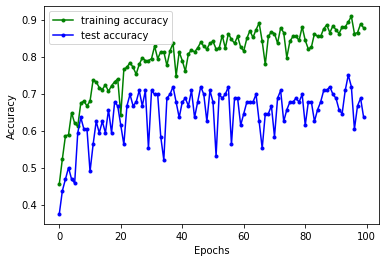

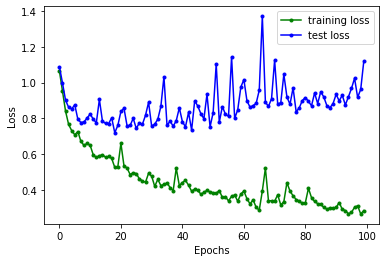

In [ ]:
# 4  layer NN without dropout and batch normalization
model_3 = DenseModel('sigmoid')
model_3.train(X_train, y_train, (X_test, y_test), 'nadam', 100, 0.01)
model_3.evaluate(X_test, y_test)
model_3.outputResult()
model_3.showPlots()

# **Dense Models with Dropout**

---



result in training set: 
train acc= 
['0.4141', '0.4453', '0.4427', '0.4245', '0.4557', '0.4583', '0.4896', '0.5104', '0.5755', '0.5495']
['0.5677', '0.5547', '0.5807', '0.5885', '0.5807', '0.5885', '0.5729', '0.6094', '0.5781', '0.6016']
['0.5625', '0.5938', '0.5755', '0.6016', '0.6016', '0.6042', '0.5938', '0.6172', '0.6068', '0.6198']
['0.6120', '0.6406', '0.6198', '0.6536', '0.6458', '0.6198', '0.6328', '0.6224', '0.6302', '0.6667']
['0.6510', '0.6510', '0.6589', '0.6328', '0.6458', '0.6589', '0.6875', '0.6641', '0.6953', '0.6536']
['0.6771', '0.6953', '0.6953', '0.6953', '0.6797', '0.6823', '0.6849', '0.6510', '0.6745', '0.6667']
['0.7005', '0.6823', '0.7083', '0.7135', '0.6745', '0.7031', '0.7161', '0.6797', '0.7135', '0.6667']
['0.7135', '0.7109', '0.6979', '0.6953', '0.7057', '0.6953', '0.7135', '0.7344', '0.6979', '0.7396']
['0.7161', '0.6797', '0.7292', '0.7135', '0.7005', '0.7135', '0.7292', '0.7057', '0.7188', '0.7266']
['0.7422', '0.7396', '0.7240', '0.7161', '0.6927', '0.

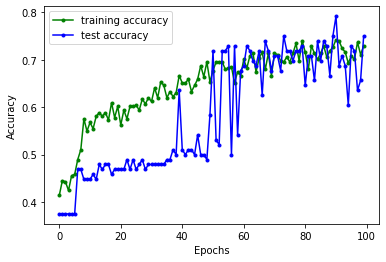

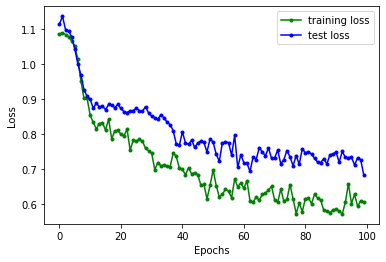

In [ ]:
# with dropout
model_4 = DenseModel('sigmoid', l=4, dropout=True)
model_4.train(X_train, y_train, (X_test, y_test), 'adamax', 100, 0.01, (1000, 0.9))
model_4.evaluate(X_test, y_test)
model_4.outputResult()
model_4.showPlots()

result in training set: 
train acc= 
['0.4870', '0.5495', '0.5755', '0.5599', '0.5521', '0.5104', '0.5781', '0.5755', '0.5729', '0.5417']
['0.5833', '0.5781', '0.5911', '0.5911', '0.5625', '0.5833', '0.5651', '0.5729', '0.6120', '0.6042']
['0.6432', '0.6380', '0.6458', '0.6380', '0.6198', '0.6406', '0.6250', '0.6380', '0.5703', '0.6094']
['0.6224', '0.5833', '0.6250', '0.6302', '0.6589', '0.6380', '0.6615', '0.6562', '0.6458', '0.6302']
['0.6406', '0.6536', '0.6276', '0.6719', '0.6667', '0.6146', '0.6562', '0.6615', '0.7083', '0.7005']
['0.7109', '0.6797', '0.6927', '0.6667', '0.7031', '0.6875', '0.6719', '0.6589', '0.7240', '0.7240']
['0.7214', '0.6667', '0.6979', '0.7188', '0.7031', '0.6979', '0.7135', '0.6979', '0.7474', '0.7057']
['0.6901', '0.6901', '0.7240', '0.7604', '0.7214', '0.7188', '0.6849', '0.6771', '0.6198', '0.6458']
['0.6693', '0.6719', '0.7031', '0.6927', '0.7188', '0.7422', '0.7396', '0.7266', '0.7161', '0.7734']
['0.7448', '0.7188', '0.7422', '0.7266', '0.6979', '0.

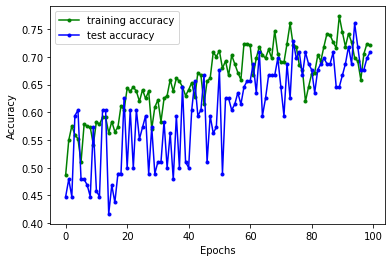

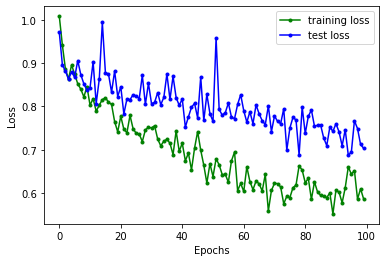

In [ ]:
# with dropout
model_5 = DenseModel('tanh', l=4, dropout=True)
model_5.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01, (100, 0.9))
model_5.evaluate(X_test, y_test)
model_5.outputResult()
model_5.showPlots()

result in training set: 
train acc= 
['0.3906', '0.4557', '0.4453', '0.4818', '0.5547', '0.5859', '0.5807', '0.6016', '0.5677', '0.5651']
['0.5911', '0.6068', '0.5911', '0.6250', '0.5729', '0.6068', '0.6354', '0.6094', '0.6354', '0.6016']
['0.6172', '0.6120', '0.6120', '0.6276', '0.6797', '0.6380', '0.6302', '0.6771', '0.6849', '0.6328']
['0.6667', '0.6693', '0.6484', '0.6354', '0.6562', '0.6354', '0.6432', '0.6354', '0.6094', '0.6120']
['0.6354', '0.6380', '0.6823', '0.6562', '0.6875', '0.6510', '0.6771', '0.6589', '0.6615', '0.6510']
['0.6536', '0.7135', '0.6484', '0.6979', '0.6823', '0.6536', '0.7031', '0.7109', '0.7188', '0.7292']
['0.7135', '0.6562', '0.7083', '0.6328', '0.6615', '0.6510', '0.7109', '0.6875', '0.6927', '0.6797']
['0.6615', '0.7083', '0.6797', '0.7109', '0.6901', '0.7083', '0.7240', '0.6953', '0.7005', '0.6849']
['0.6979', '0.6719', '0.6901', '0.7109', '0.7422', '0.6901', '0.7005', '0.7292', '0.6979', '0.7188']
['0.7526', '0.7109', '0.6953', '0.7135', '0.6693', '0.

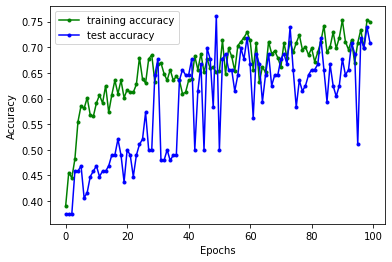

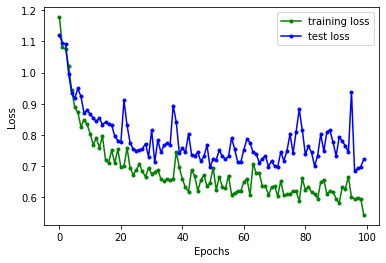

In [ ]:
# with dropout
model_6 = DenseModel('sigmoid', l=4, dropout=True)
model_6.train(X_train, y_train, (X_test, y_test), 'nadam', 100, 0.01, (100, 0.90))
model_6.evaluate(X_test, y_test)
model_6.outputResult()
model_6.showPlots()

result in training set: 
train acc= 
['0.3229', '0.4427', '0.4609', '0.4271', '0.4375', '0.4557', '0.5000', '0.5391', '0.5469', '0.5833']
['0.6094', '0.5651', '0.5703', '0.5911', '0.5599', '0.6120', '0.6042', '0.5964', '0.6042', '0.6406']
['0.6068', '0.6042', '0.6276', '0.6302', '0.6432', '0.6146', '0.6302', '0.6354', '0.6562', '0.6094']
['0.5938', '0.6719', '0.6432', '0.6432', '0.6849', '0.6484', '0.6745', '0.6589', '0.6302', '0.6406']
['0.6536', '0.6745', '0.6562', '0.6927', '0.6719', '0.7083', '0.6875', '0.6901', '0.6901', '0.6276']
['0.6615', '0.6589', '0.6510', '0.6510', '0.6719', '0.6667', '0.6693', '0.6354', '0.6276', '0.6354']
['0.6406', '0.6771', '0.6562', '0.6979', '0.6693', '0.6771', '0.6641', '0.6589', '0.6875', '0.7031']
['0.6875', '0.6823', '0.6667', '0.6875', '0.7005', '0.6276', '0.6693', '0.6901', '0.7135', '0.6953']
['0.7682', '0.7005', '0.6953', '0.6823', '0.6771', '0.7214', '0.7083', '0.7031', '0.7161', '0.7005']
['0.6901', '0.7161', '0.6562', '0.6745', '0.7370', '0.

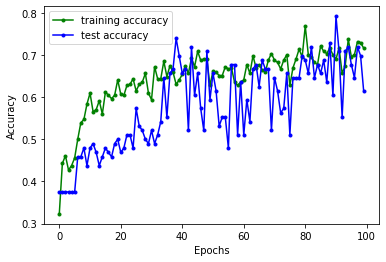

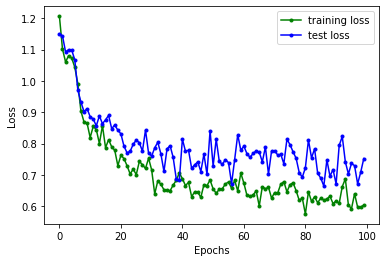

In [ ]:
# 5 layer NN with dropout
model_7 = DenseModel('sigmoid', l=4, dropout=True)
model_7.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01, (1000, 0.92))
model_7.evaluate(X_test, y_test)
model_7.outputResult()
model_7.showPlots()

# **Dense Models with batch normalization**

---



result in training set: 
train acc= 
['0.5000', '0.6354', '0.6823', '0.7214', '0.7448', '0.7604', '0.7786', '0.7812', '0.7917', '0.7917']
['0.8125', '0.8229', '0.8125', '0.8151', '0.8672', '0.8411', '0.8359', '0.8646', '0.8542', '0.8646']
['0.8516', '0.8438', '0.8698', '0.8854', '0.8880', '0.9062', '0.8724', '0.8672', '0.8880', '0.8620']
['0.8724', '0.8698', '0.8490', '0.9219', '0.9115', '0.9115', '0.9089', '0.9219', '0.9089', '0.8906']
['0.9089', '0.9141', '0.9115', '0.8906', '0.8984', '0.9323', '0.9375', '0.9245', '0.9375', '0.9141']
['0.9245', '0.9089', '0.9141', '0.9271', '0.9271', '0.8880', '0.9323', '0.9036', '0.9453', '0.9297']
['0.9115', '0.9531', '0.9375', '0.9401', '0.9219', '0.9349', '0.9297', '0.9479', '0.9375', '0.9453']
['0.9479', '0.9557', '0.9531', '0.9505', '0.9740', '0.9010', '0.9453', '0.9141', '0.9609', '0.9271']
['0.9531', '0.9453', '0.9375', '0.9297', '0.9297', '0.9427', '0.9245', '0.9375', '0.9427', '0.9375']
['0.9297', '0.9505', '0.9271', '0.9401', '0.9505', '0.

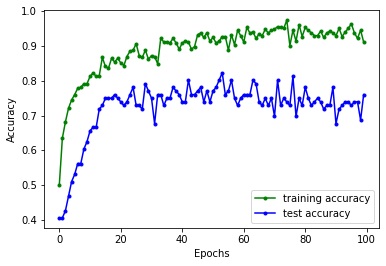

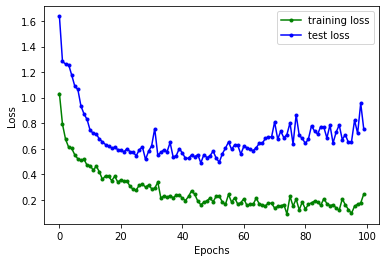

In [ ]:
model_1 = DenseModel('relu', batch_normalization=True)
model_1.train(X_train, y_train, (X_test, y_test), 'sgd', 100, 0.1, (1000, 0.99))
model_1.evaluate(X_test, y_test)
model_1.outputResult()
model_1.showPlots()

result in training set: 
train acc= 
['0.5547', '0.7422', '0.7005', '0.7786', '0.7552', '0.7995', '0.7682', '0.7630', '0.7943', '0.7917']
['0.7969', '0.7812', '0.8359', '0.7995', '0.8047', '0.7917', '0.8620', '0.8490', '0.8281', '0.8411']
['0.8307', '0.8516', '0.8646', '0.8620', '0.8516', '0.8333', '0.8776', '0.8750', '0.8854', '0.9010']
['0.8776', '0.8802', '0.8750', '0.8906', '0.8776', '0.9036', '0.8646', '0.9245', '0.8906', '0.9062']
['0.9245', '0.9245', '0.9245', '0.9245', '0.9245', '0.9062', '0.9089', '0.9193', '0.9271', '0.9193']
['0.9323', '0.9089', '0.9375', '0.9219', '0.9193', '0.9349', '0.9375', '0.9297', '0.9297', '0.9115']
['0.9167', '0.9505', '0.9245', '0.9401', '0.9297', '0.9193', '0.9401', '0.9323', '0.9557', '0.9089']
['0.9479', '0.9401', '0.9401', '0.9323', '0.9583', '0.9688', '0.9505', '0.9505', '0.9609', '0.9557']
['0.9635', '0.9323', '0.9349', '0.9688', '0.9583', '0.9661', '0.9271', '0.9375', '0.9427', '0.9583']
['0.9245', '0.9271', '0.9740', '0.9531', '0.9688', '0.

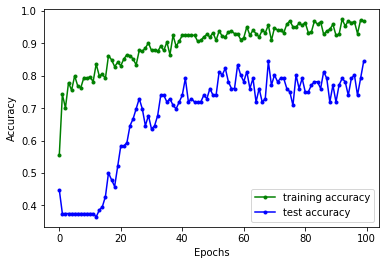

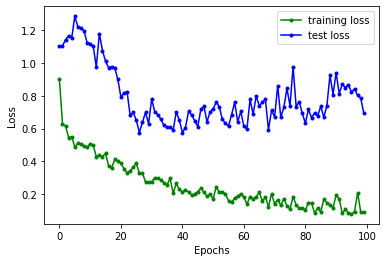

In [ ]:
model_2 = DenseModel('sigmoid', batch_normalization=True)
model_2.train(X_train, y_train, (X_test, y_test), 'rms', 100, 0.01, (1000, 0.95))
model_2.evaluate(X_test, y_test)
model_2.outputResult()
model_2.showPlots()

result in training set: 
train acc= 
['0.5417', '0.7344', '0.7292', '0.7760', '0.7969', '0.7786', '0.7760', '0.7708', '0.7604', '0.7943']
['0.7943', '0.7865', '0.8333', '0.8125', '0.8073', '0.8255', '0.8411', '0.8594', '0.8359', '0.8542']
['0.8385', '0.8568', '0.8516', '0.8802', '0.8516', '0.8724', '0.8594', '0.8620', '0.8932', '0.8724']
['0.8958', '0.9141', '0.8880', '0.9036', '0.9219', '0.8984', '0.8828', '0.8958', '0.9010', '0.9089']
['0.9167', '0.9297', '0.8906', '0.9141', '0.9141', '0.9141', '0.9453', '0.9479', '0.9089', '0.9115']
['0.9479', '0.9609', '0.9193', '0.9193', '0.9401', '0.9219', '0.9453', '0.9167', '0.9479', '0.9609']
['0.9375', '0.9427', '0.9297', '0.9557', '0.9427', '0.9479', '0.9323', '0.9583', '0.9688', '0.9349']
['0.9661', '0.9427', '0.9453', '0.9531', '0.9557', '0.9661', '0.9453', '0.9453', '0.9401', '0.9193']
['0.9531', '0.9505', '0.9505', '0.9688', '0.9714', '0.9635', '0.9688', '0.9583', '0.9714', '0.9661']
['0.9297', '0.9661', '0.9557', '0.9557', '0.9479', '0.

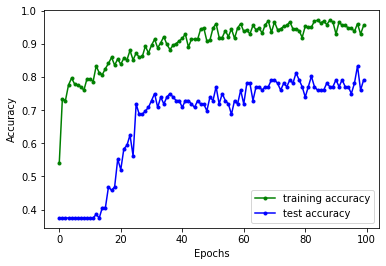

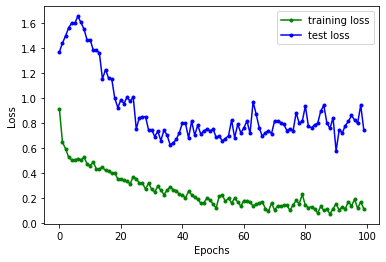

In [ ]:
model_3 = DenseModel('sigmoid', batch_normalization=True)
model_3.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01)
model_3.evaluate(X_test, y_test)
model_3.outputResult()
model_3.showPlots()

result in training set: 
train acc= 
['0.5417', '0.6771', '0.7708', '0.8021', '0.7786', '0.8359', '0.8385', '0.8490', '0.8438', '0.8516']
['0.8568', '0.8307', '0.8828', '0.8594', '0.8411', '0.8724', '0.8932', '0.8880', '0.8776', '0.8698']
['0.8776', '0.9349', '0.8984', '0.9089', '0.9141', '0.9089', '0.9271', '0.9349', '0.9349', '0.9141']
['0.9141', '0.9297', '0.9661', '0.9453', '0.9245', '0.9271', '0.9688', '0.9479', '0.9557', '0.9323']
['0.9089', '0.9427', '0.9375', '0.9401', '0.9583', '0.9401', '0.9453', '0.9401', '0.9245', '0.9271']
['0.9531', '0.9297', '0.9531', '0.9531', '0.9375', '0.9557', '0.9688', '0.9766', '0.9557', '0.9609']
['0.9609', '0.9661', '0.9766', '0.9714', '0.9557', '0.9714', '0.9453', '0.9740', '0.9505', '0.9818']
['0.9661', '0.9714', '0.9688', '0.9740', '0.9661', '0.9635', '0.9714', '0.9531', '0.9635', '0.9583']
['0.9714', '0.9818', '0.9609', '0.9609', '0.9661', '0.9635', '0.9609', '0.9583', '0.9688', '0.9740']
['0.9688', '0.9635', '0.9714', '0.9661', '0.9583', '0.

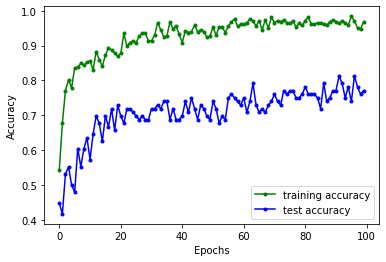

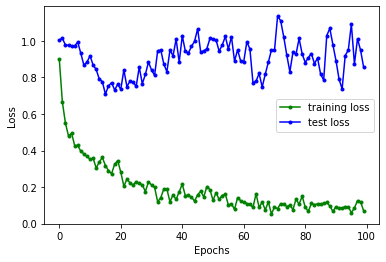

In [ ]:
model_4 = DenseModel('tanh', batch_normalization=True)
model_4.train(X_train, y_train, (X_test, y_test), 'adam', 100, 0.01)
model_4.evaluate(X_test, y_test)
model_4.outputResult()
model_4.showPlots()

# **Top 3 Models**

---



**Model 1 (Sigmoid-RMS-Batch Normalization)**

In [ ]:
# k fold on (sigmoid-RMS 5 layer) with batch normalization
activation = 'sigmoid'
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate=0.01,
                      decay_steps=1000,
                      decay_rate=0.95,
                      staircase=True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
kfoldOnModel(X, y, activation, optimizer, layers_number=3, batch_normalization=True, k=5)

------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.4854085147380829  Acc= 84.375% 

confusion matrix: 
 [[19  9  0]
 [ 1 28  2]
 [ 0  3 34]]
              precision    recall  f1-score   support

           H      0.950     0.679     0.792        28
           M      0.700     0.903     0.789        31
           L      0.944     0.919     0.932        37

   micro avg      0.844     0.844     0.844        96
   macro avg      0.865     0.834     0.837        96
weighted avg      0.867     0.844     0.845        96
 samples avg      0.844     0.844     0.844        96

------------------------------------------------------------------------
Training for fold 2 ...
Result for fold 2: Loss= 1.1613956689834595  Acc= 70.83333134651184% 

confusion matrix: 
 [[20  8  0]
 [11 32  6]
 [ 1  2 16]]
              precision    recall  f1-score   support

           H      0.625     0.714     0.667        28
           M     

**Model 2 (Sigmoid-Adam-Batch Normalization)**

In [ ]:
# k fold on (sigmoid-Adam 5 layer) with batch normalization
activation = 'sigmoid'
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate=0.01,
                      decay_steps=1000,
                      decay_rate=0.95,
                      staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
kfoldOnModel(X, y, activation, optimizer, layers_number=3, batch_normalization=True, k=5)

------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 1.0181430578231812  Acc= 68.75% 

confusion matrix: 
 [[19  8  0]
 [ 8 29 10]
 [ 0  4 18]]
              precision    recall  f1-score   support

           H      0.704     0.704     0.704        27
           M      0.707     0.617     0.659        47
           L      0.643     0.818     0.720        22

   micro avg      0.688     0.688     0.688        96
   macro avg      0.685     0.713     0.694        96
weighted avg      0.692     0.688     0.686        96
 samples avg      0.688     0.688     0.688        96

------------------------------------------------------------------------
Training for fold 2 ...
Result for fold 2: Loss= 1.0924524068832397  Acc= 70.83333134651184% 

confusion matrix: 
 [[20  7  1]
 [ 4 32  5]
 [ 1 10 16]]
              precision    recall  f1-score   support

           H      0.800     0.714     0.755        28
           M      

**Model 3 (Relu-SGD-Batch Normalization)**

In [ ]:
# k fold on (Relu-SGD 5 layer) with batch normalization
activation = 'relu'
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate=0.1,
                      decay_steps=1000,
                      decay_rate=0.99,
                      staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
kfoldOnModel(X, y, activation, optimizer, layers_number=3, batch_normalization=True, k=5)

------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.8111419081687927  Acc= 79.16666865348816% 

confusion matrix: 
 [[23  7  0]
 [ 7 25  4]
 [ 1  1 28]]
              precision    recall  f1-score   support

           H      0.742     0.767     0.754        30
           M      0.758     0.694     0.725        36
           L      0.875     0.933     0.903        30

   micro avg      0.792     0.792     0.792        96
   macro avg      0.792     0.798     0.794        96
weighted avg      0.789     0.792     0.790        96
 samples avg      0.792     0.792     0.792        96

------------------------------------------------------------------------
Training for fold 2 ...
Result for fold 2: Loss= 0.6973358988761902  Acc= 69.79166865348816% 

confusion matrix: 
 [[18  8  1]
 [13 32  5]
 [ 0  2 17]]
              precision    recall  f1-score   support

           H      0.581     0.667     0.621        27
      